In [1]:
import cracktools as ct
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import skimage

In [3]:
images_names = ct.tools.get_files(folder = 'crack images',formats = ['png','jpg'],basename = False)

### Select image number (a) and put 2 endpoints and 1 middlepoint (in this sequence) for all crack segments

In [17]:
#43
a = 0

In [18]:
image_size = 5

image_name = images_names[a]

# with open(name) as json_file:
#     data = json.load(json_file)
#     image_name = data['file_name']
image = ct.tools.image_load(image_name)
ptss = ct.tools.Draw().points(image[:,:,::-1],image_size,move_x = 0,move_y = 0)
mask = np.zeros([image.shape[0],image.shape[1],int(len(ptss)/3)])
crack_tracks = {}


In [19]:
cv2.destroyAllWindows()

### Select crack segment (b)

In [20]:
b = 0

choose:

y_margin and x_margin - to fit crack in the image box below

downsample_factor - to decrease image resolution and increase speed

color_channel (0,1,2) - to make crack most visible 

In [21]:
black_crack = 1

y_margin = 45
x_margin = 45
downsample_factor = 4
color_channel = 1



In [22]:
if black_crack==1:
    func = np.min
elif  black_crack==-1:
    func = np.max

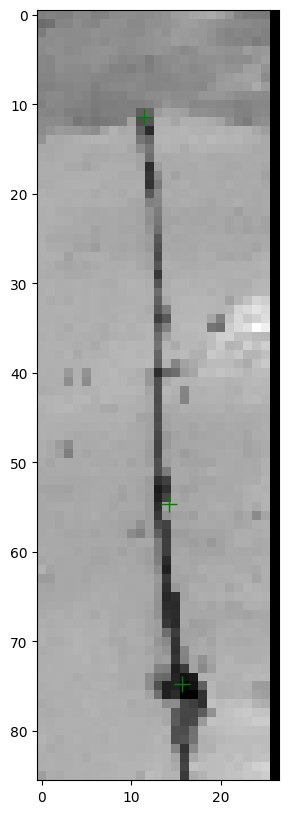

In [23]:
pts = ptss[b*3:b*3+3]


image_crop,pts_crop = ct.tools.image_crop(image,pts[0],pts[1],pts,y_margin,x_margin)

image_crop_down = skimage.measure.block_reduce(image_crop, block_size=(downsample_factor, downsample_factor, 1),
                                           func=func, cval=0, func_kwargs=None)
pts_crop_down = [x / downsample_factor for x in pts_crop]


image_down = skimage.measure.block_reduce(image, block_size=(downsample_factor, downsample_factor, 1),
                                           func=np.min, cval=0, func_kwargs=None)
pts_down = [x / downsample_factor for x in pts]


ct.tools.show_image(image_crop_down[:,:,color_channel],frame_size = 10, pts = pts_crop_down)

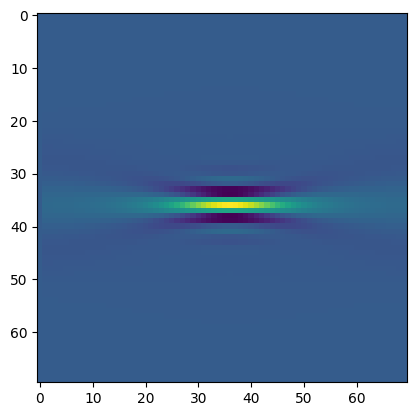

In [24]:
size = 70
nOrientations = 32
design = "N"
inflectionPoint = 0.5
mnOrder = 8
splineOrder = 3
overlapFactor = 1
dcStdDev = 8
directional = False
window_size = 70

cw = ct.os.CheckWavelet(window_size = window_size, size = size, nOrientations = nOrientations, design = design, 
                inflectionPoint = inflectionPoint, mnOrder = mnOrder, splineOrder = splineOrder,
                overlapFactor = overlapFactor, dcStdDev = dcStdDev, directional = directional,
                display_orientations=[8])
plt.imshow(cw[0,:,:])

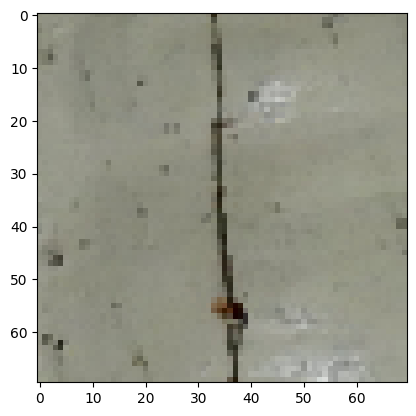

In [25]:
d = int(window_size/2)
fig = plt.figure()
# fig.set_size_inches(18.5, 10.5)
plt.imshow(image_down[int(pts_down[2][1])-d:int(pts_down[2][1])+d,
                           int(pts_down[2][0])-d:int(pts_down[2][0])+d],cmap = 'gray')

In [26]:
osGFCost = ct.os.OrientationScoreTransform(image_crop_down[:,:,color_channel]/255*black_crack, size = size, 
                                           nOrientations = nOrientations, design = design, 
                                           inflectionPoint = inflectionPoint, mnOrder = mnOrder, 
                                           splineOrder = splineOrder, overlapFactor = overlapFactor, 
                                           dcStdDev = dcStdDev, directional = directional)

In [27]:
ksi = 1
zeta = 1
sigmas = [1,2]
sigmas_ext = 1
multiscalecostLIFExtReg = ct.os.MultiScaleVesselness(osGFCost.real,ksi,1,sigmas,"LIF",sigmas_ext = sigmas_ext)

1
2


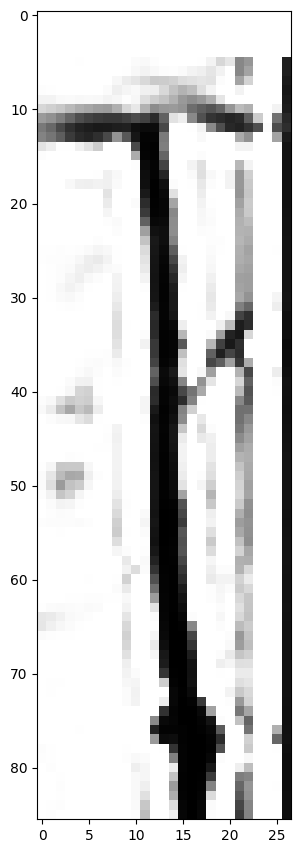

In [28]:
lambdaa = 200
p = 1.5

costmultiscale = ct.os.MultiScaleVesselnessFilter(multiscalecostLIFExtReg)
costFunction = ct.os.CostFunction(costmultiscale,lambdaa = lambdaa, p = p)
c00 = np.min(ct.os.Rescale(costFunction),axis = 0)
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(c00,cmap = 'gray')

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.226 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Done.


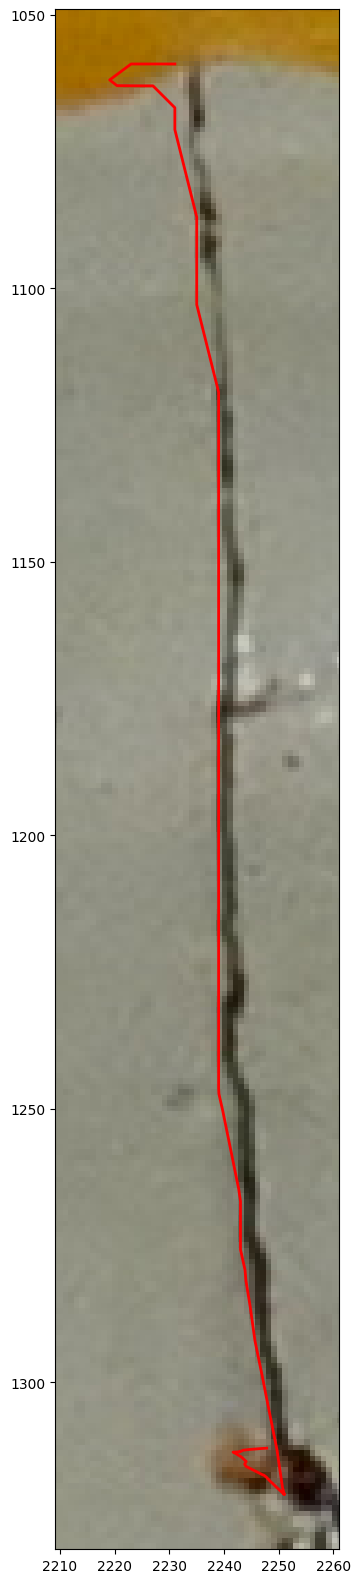

In [29]:
track_crop_down = ct.tracking.fast_marching(costFunction,pts_crop_down[0],pts_crop_down[1],g11=1,g22=100,g33=100)
track_crop_down[0] = track_crop_down[0]-0.5
track_crop_down[1] = track_crop_down[1]-0.5
track_crop = track_crop_down.copy()
track_crop[0] = track_crop_down[0]*downsample_factor
track_crop[1] = track_crop_down[1]*downsample_factor

track = ct.tools.track_crop_to_full(track_crop,pts[0],pts[1],y_margin,x_margin)

ct.tools.draw_track(image,track,frame_size = 20,limits_x = 10, limits_y = 10,track_color = 'r',track_width = 2)

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.018 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.018 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


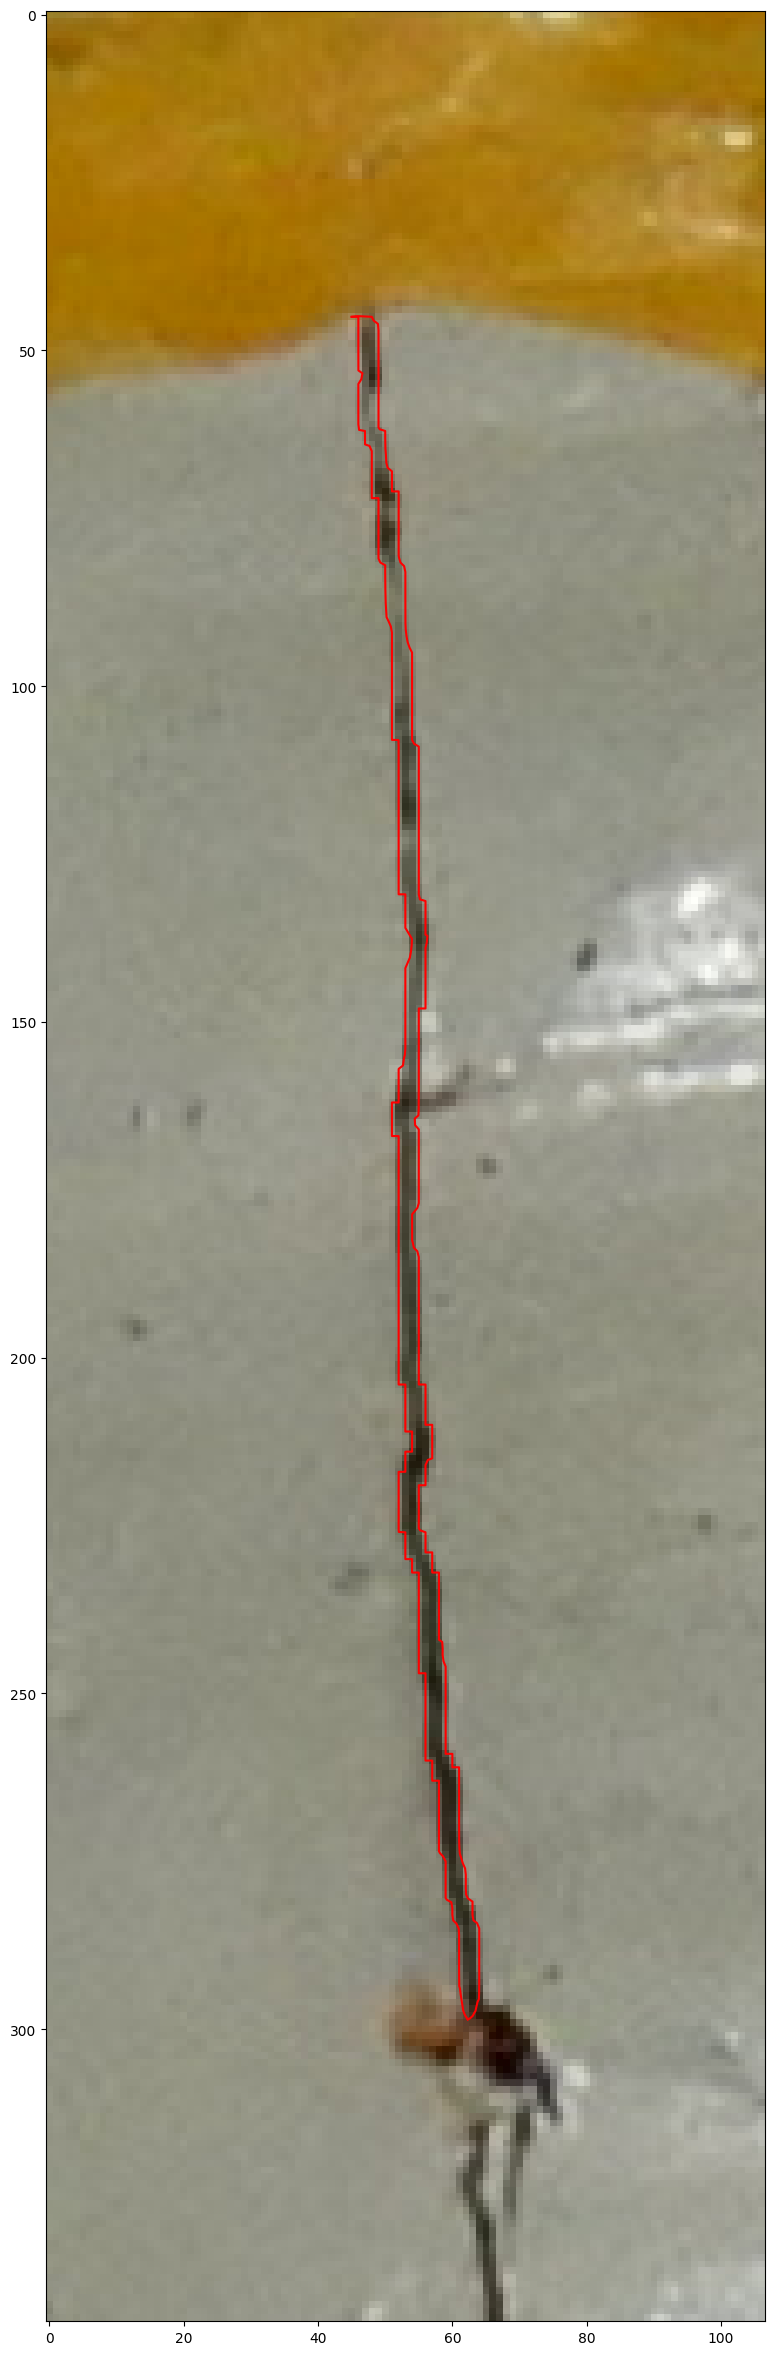

In [30]:
mu = 0
l = 5
p = 14
window_half_size=45

edge_mask1, edge_mask2 = ct.segmentation.edge_masks(image[:,:,color_channel]*black_crack,np.array(track),window_half_size=window_half_size)

edge_mask1_crop,pts_crop = ct.tools.image_crop(edge_mask1[:,:,np.newaxis],pts[0],pts[1],pts,y_margin,x_margin)
edge_mask2_crop,pts_crop = ct.tools.image_crop(edge_mask2[:,:,np.newaxis],pts[0],pts[1],pts,y_margin,x_margin)

track_e1_crop, track_e2_crop = ct.segmentation.edges_tracking(image_crop[:,:,color_channel], pts_crop, 
                                                    edge_mask1_crop,edge_mask2_crop, mu = mu,l = l, p = p)
track_e1_crop = track_e1_crop[::-1]
track_e2_crop = track_e2_crop[::-1]

track_e1_crop[0] = track_e1_crop[0] - 0.5
track_e2_crop[0] = track_e2_crop[0] - 0.5

track_e1_crop[1] = track_e1_crop[1] - 0.5
track_e2_crop[1] = track_e2_crop[1] - 0.5

fig = plt.figure()
fig.set_size_inches(30, 30)
plt.imshow(image_crop)
plt.plot(track_e1_crop[0],track_e1_crop[1],'r')
plt.plot(track_e2_crop[0],track_e2_crop[1],'r')
# plt.plot(GT[0],GT[1],'g')
# plt.xlim([2000,3000])
# plt.ylim([2000,2500])
plt.show()

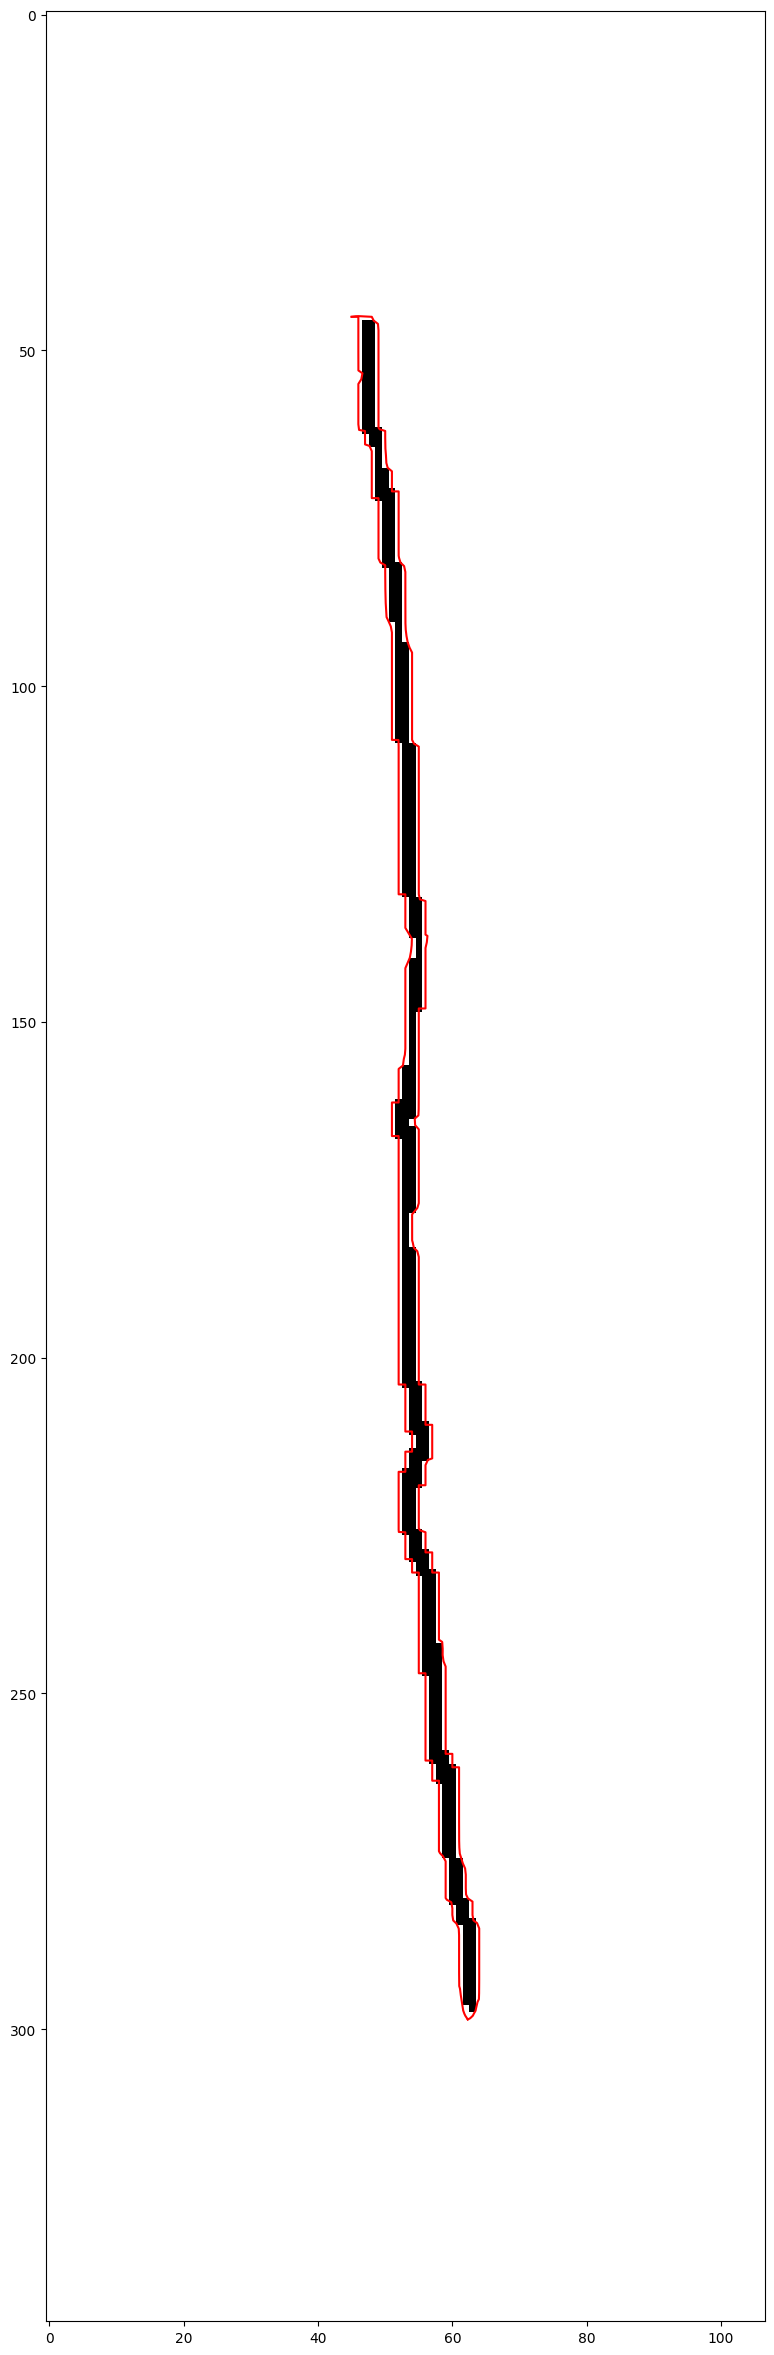

In [31]:
track_e1 = ct.tools.track_crop_to_full(track_e1_crop,pts[0],pts[1],y_margin,x_margin)
track_e2 = ct.tools.track_crop_to_full(track_e2_crop,pts[0],pts[1],y_margin,x_margin)

edge_x = np.concatenate((track_e1[1][::-1],track_e2[1]))
edge_y = np.concatenate((track_e1[0][::-1],track_e2[0]))

mask_FM = ct.segmentation.create_mask(image,edge_y,edge_x)
mask[:,:,b] = mask_FM
track = [list(x) for x in track]
crack_tracks[str(b)] = track
m = np.sum(mask,axis = 2)
m[m>=1] = 1.0

m_crop,pts_crop = ct.tools.image_crop(m[:,:,np.newaxis],pts[0],pts[1],pts,y_margin,x_margin)

fig = plt.figure()
fig.set_size_inches(30, 30)
plt.imshow(m_crop*-1,cmap = 'gray')
plt.plot(track_e1_crop[0],track_e1_crop[1],'r')
plt.plot(track_e2_crop[0],track_e2_crop[1],'r')
# plt.plot(edge_y,edge_x)
# plt.xlim([2400,2500])
# plt.ylim([2750,2300])
plt.show()

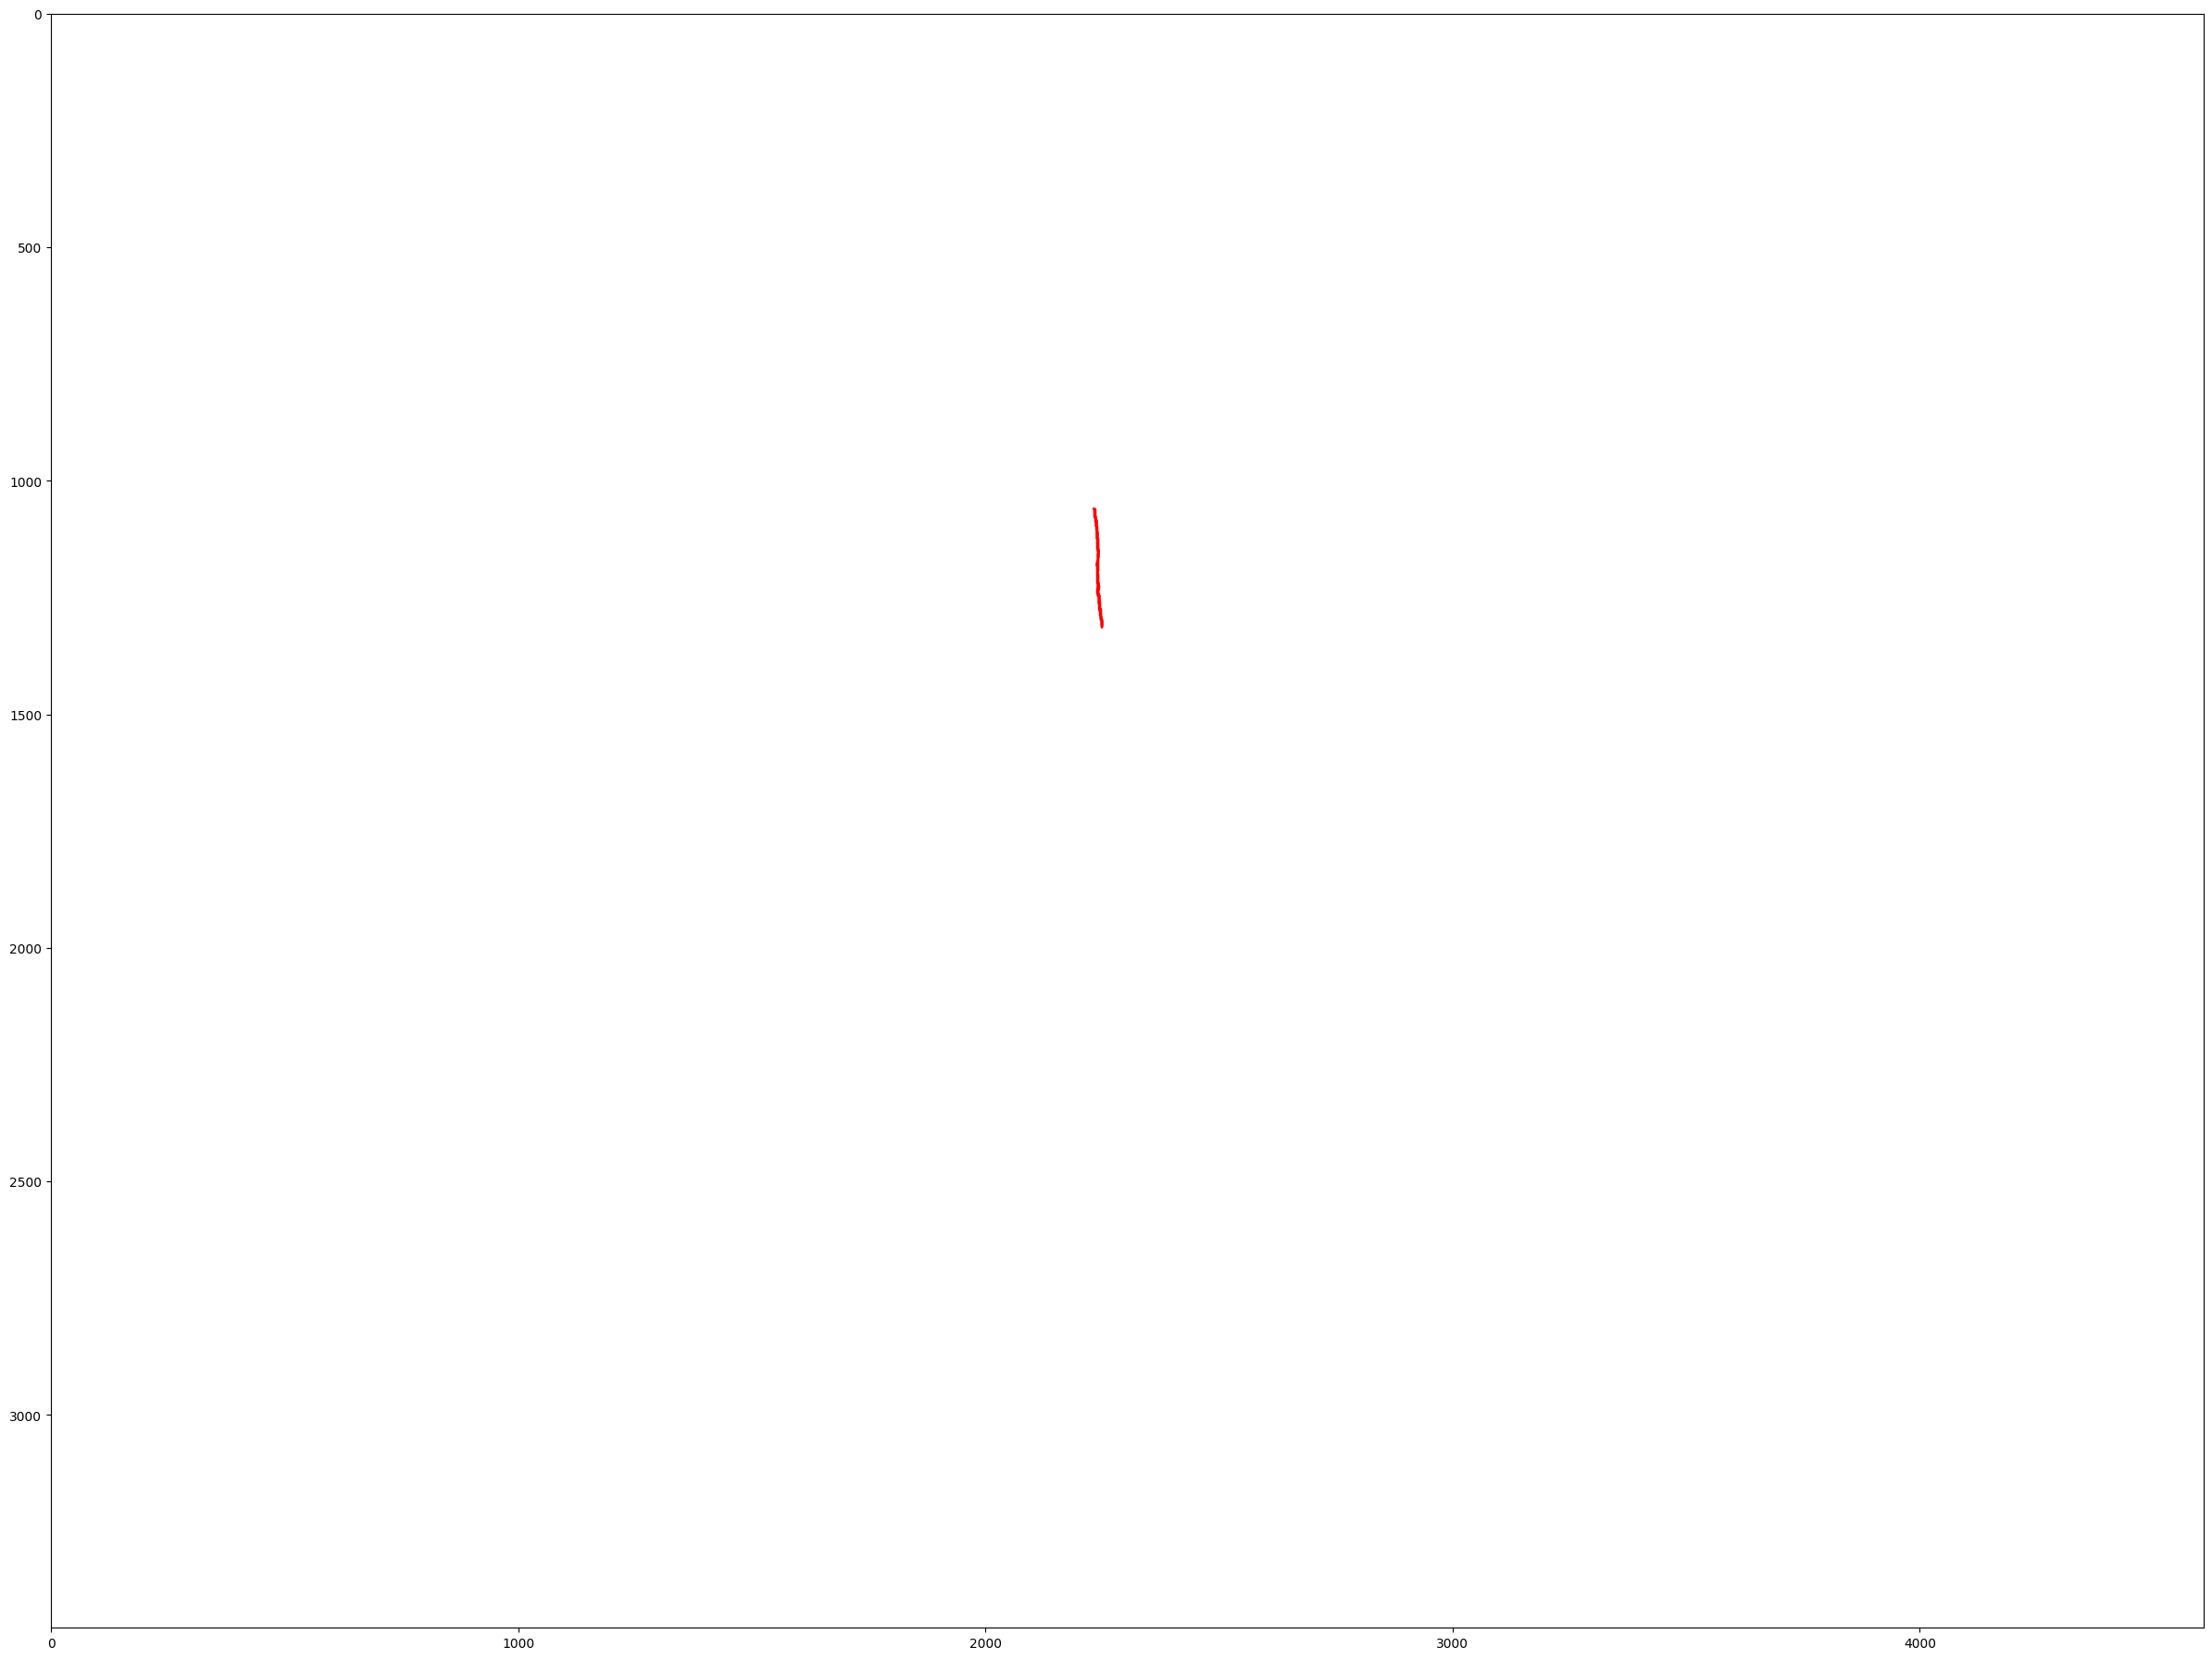

In [32]:
fig = plt.figure()
fig.set_size_inches(30, 30)
plt.imshow(m*-1,cmap = 'gray')
plt.plot(track_e1[0],track_e1[1],'r')
plt.plot(track_e2[0],track_e2[1],'r')
# plt.plot(edge_y,edge_x)
# plt.xlim([2400,2500])
# plt.ylim([2750,2300])
plt.show()

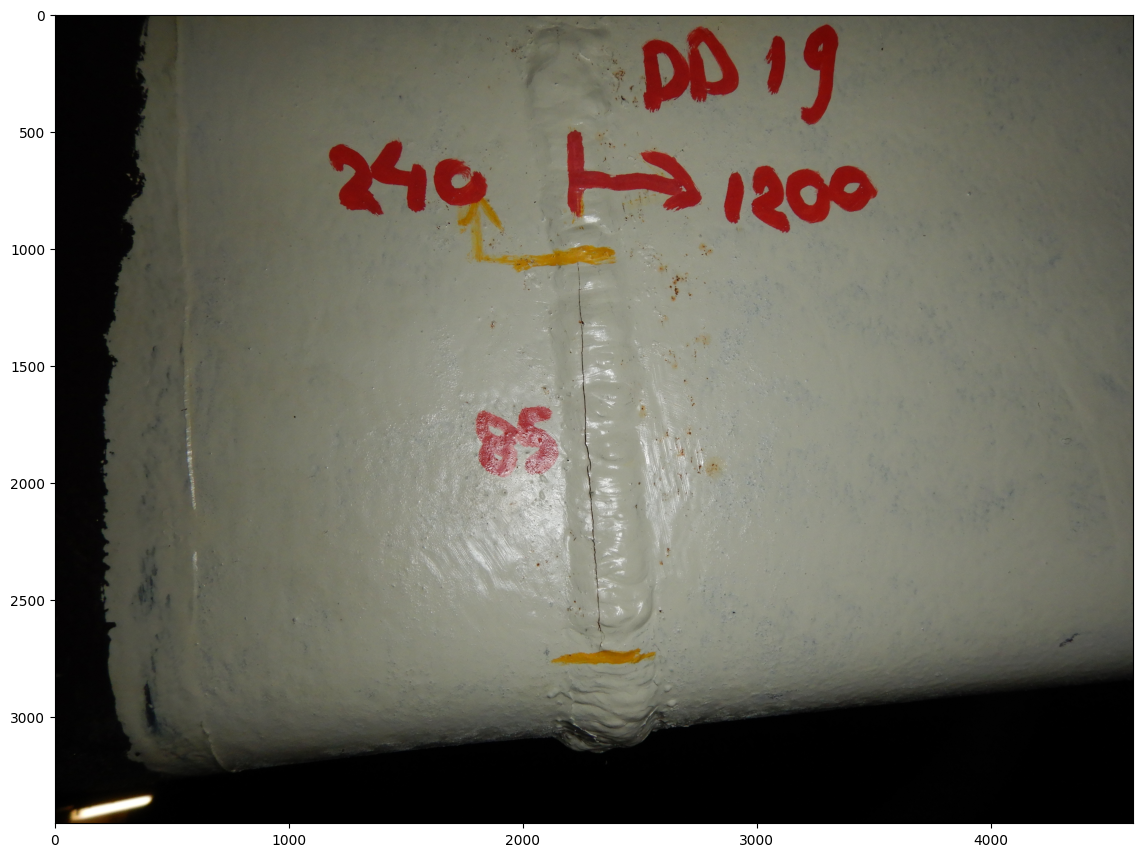

In [33]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(image)
# plt.plot(track_e1[0],track_e1[1],'r')
# plt.plot(track_e2[0],track_e2[1],'r')
# plt.plot(track[0],track[1])
# plt.xlim([2370,2400])
# plt.ylim([2500,2350])
plt.show()

# Save annotation (after all crack segments-b are done)

In [48]:
data = {}
data["file_name"] = os.path.splitext(os.path.basename(image_name))[0]
data["annotations"] = {}
data["annotations"]["cracks end-points"] = {}
for i in range(0,int(len(ptss)/3)):
    data['annotations']["cracks end-points"][str(i)] = [list(x.astype('float64')) for x in ptss[i*3:i*3+2]]

m = np.sum(np.array(mask),axis = 0)
m[m>=1] = 1.0
crack_pixels = np.argwhere(m==1.0)
data["annotations"]["crack_pixels"] = crack_pixels.tolist()
data["annotations"]['tracks'] = crack_tracks
json_file = json.dumps(data)
json_file = json.dumps(data)

with open(os.path.splitext(image_name)[0]+'.json', 'w') as f:    
    f.write(json_file)   